[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-aps.ipynb)

Set Up

In [1]:
# Upload the model file
from google.colab import files
uploaded = files.upload()

Saving conformal_raps.zip to conformal_raps.zip
Saving my_utils.py to my_utils.py
Saving my_conformal.py to my_conformal.py
Saving validation_dataset.zip to validation_dataset.zip
Saving resnet_18_derm_model_test_v2.pt to resnet_18_derm_model_test_v2.pt


In [4]:
zip_file = 'validation_dataset.zip'

# Extract the contents of the ZIP file
import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sys
import random
import time
import collections, itertools, json, os, pathlib, sys


#imports from Conforamal RAPS
from conformal_raps.conformal import *
from conformal_raps.utils import *

#PyTorch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [8]:
cudnn.benchmark = True
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device = " + str(device))

Device = cuda:0


In [6]:
#setting seeds to 0 for reproducability
np.random.seed(seed=0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

In [9]:
#load model
model_path = r"resnet_18_derm_model_test_v2.pt"
model = torch.load(model_path)
# model.to(device)
model = torch.nn.DataParallel(model)  # wdk...for multi-gpu instances
#model to eval mode
_ = model.eval()

#load data
root = r'validation_dataset'
validate_path = os.path.join(root, 'val')

calibration_dataset, validation_dataset = torch.utils.data.random_split(
    torchvision.datasets.ImageFolder(validate_path, transform), [100, 890-100]) #[num, num_image-num]

calib_loader = torch.utils.data.DataLoader(
    calibration_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [12]:
# Get softmax predictions from the model
def get_predictions(loader, model):
    smx = []
    labels = []
    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        smx.append(probs.cpu().numpy())
        labels.append(targets.cpu().numpy())

    smx = np.concatenate(smx, axis=0)
    labels = np.concatenate(labels, axis=0)
    return smx, labels

# Get predictions and labels for calibration and validation datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cal_smx, cal_labels = get_predictions(calib_loader, model)
val_smx, val_labels = get_predictions(val_loader, model)

n = cal_labels.shape[0]
alpha = 0.05

cal_pi = cal_smx.argsort(1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(n), cal_labels]

qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")

val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

The empirical coverage is: 0.959493670886076


<ipython-input-12-97bcf129787c>:30: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")


In [15]:
#prefilling parameters
num_images = 890
num_calib = 100

class_names = {0: 'allergic_contact_dermatitis', 1: 'basal_cell_carcinoma', 2: 'folliculitis', 
               3: 'lichen_planus', 4: 'lupus_erythematosus', 5: 'neutrophilic_dermatoses', 
               6: 'photodermatoses', 7: 'psoriasis', 8: 'sarcoidosis', 9: 'squamous_cell_carcinoma'}
class_names = list(class_names.values())

Image 0 has label 'psoriasis', and the predictive set is ['lichen_planus', 'psoriasis'].
Image 1 has label 'neutrophilic_dermatoses', and the predictive set is ['allergic_contact_dermatitis', 'basal_cell_carcinoma', 'lichen_planus', 'lupus_erythematosus', 'neutrophilic_dermatoses', 'photodermatoses', 'psoriasis', 'sarcoidosis', 'squamous_cell_carcinoma'].
Image 2 has label 'lupus_erythematosus', and the predictive set is ['allergic_contact_dermatitis', 'basal_cell_carcinoma', 'lichen_planus', 'neutrophilic_dermatoses', 'photodermatoses', 'psoriasis', 'sarcoidosis', 'squamous_cell_carcinoma'].
Image 3 has label 'psoriasis', and the predictive set is ['allergic_contact_dermatitis', 'lichen_planus', 'lupus_erythematosus', 'neutrophilic_dermatoses', 'psoriasis', 'sarcoidosis', 'squamous_cell_carcinoma'].
Image 4 has label 'psoriasis', and the predictive set is ['allergic_contact_dermatitis', 'lichen_planus', 'lupus_erythematosus', 'neutrophilic_dermatoses', 'photodermatoses', 'psoriasis', 

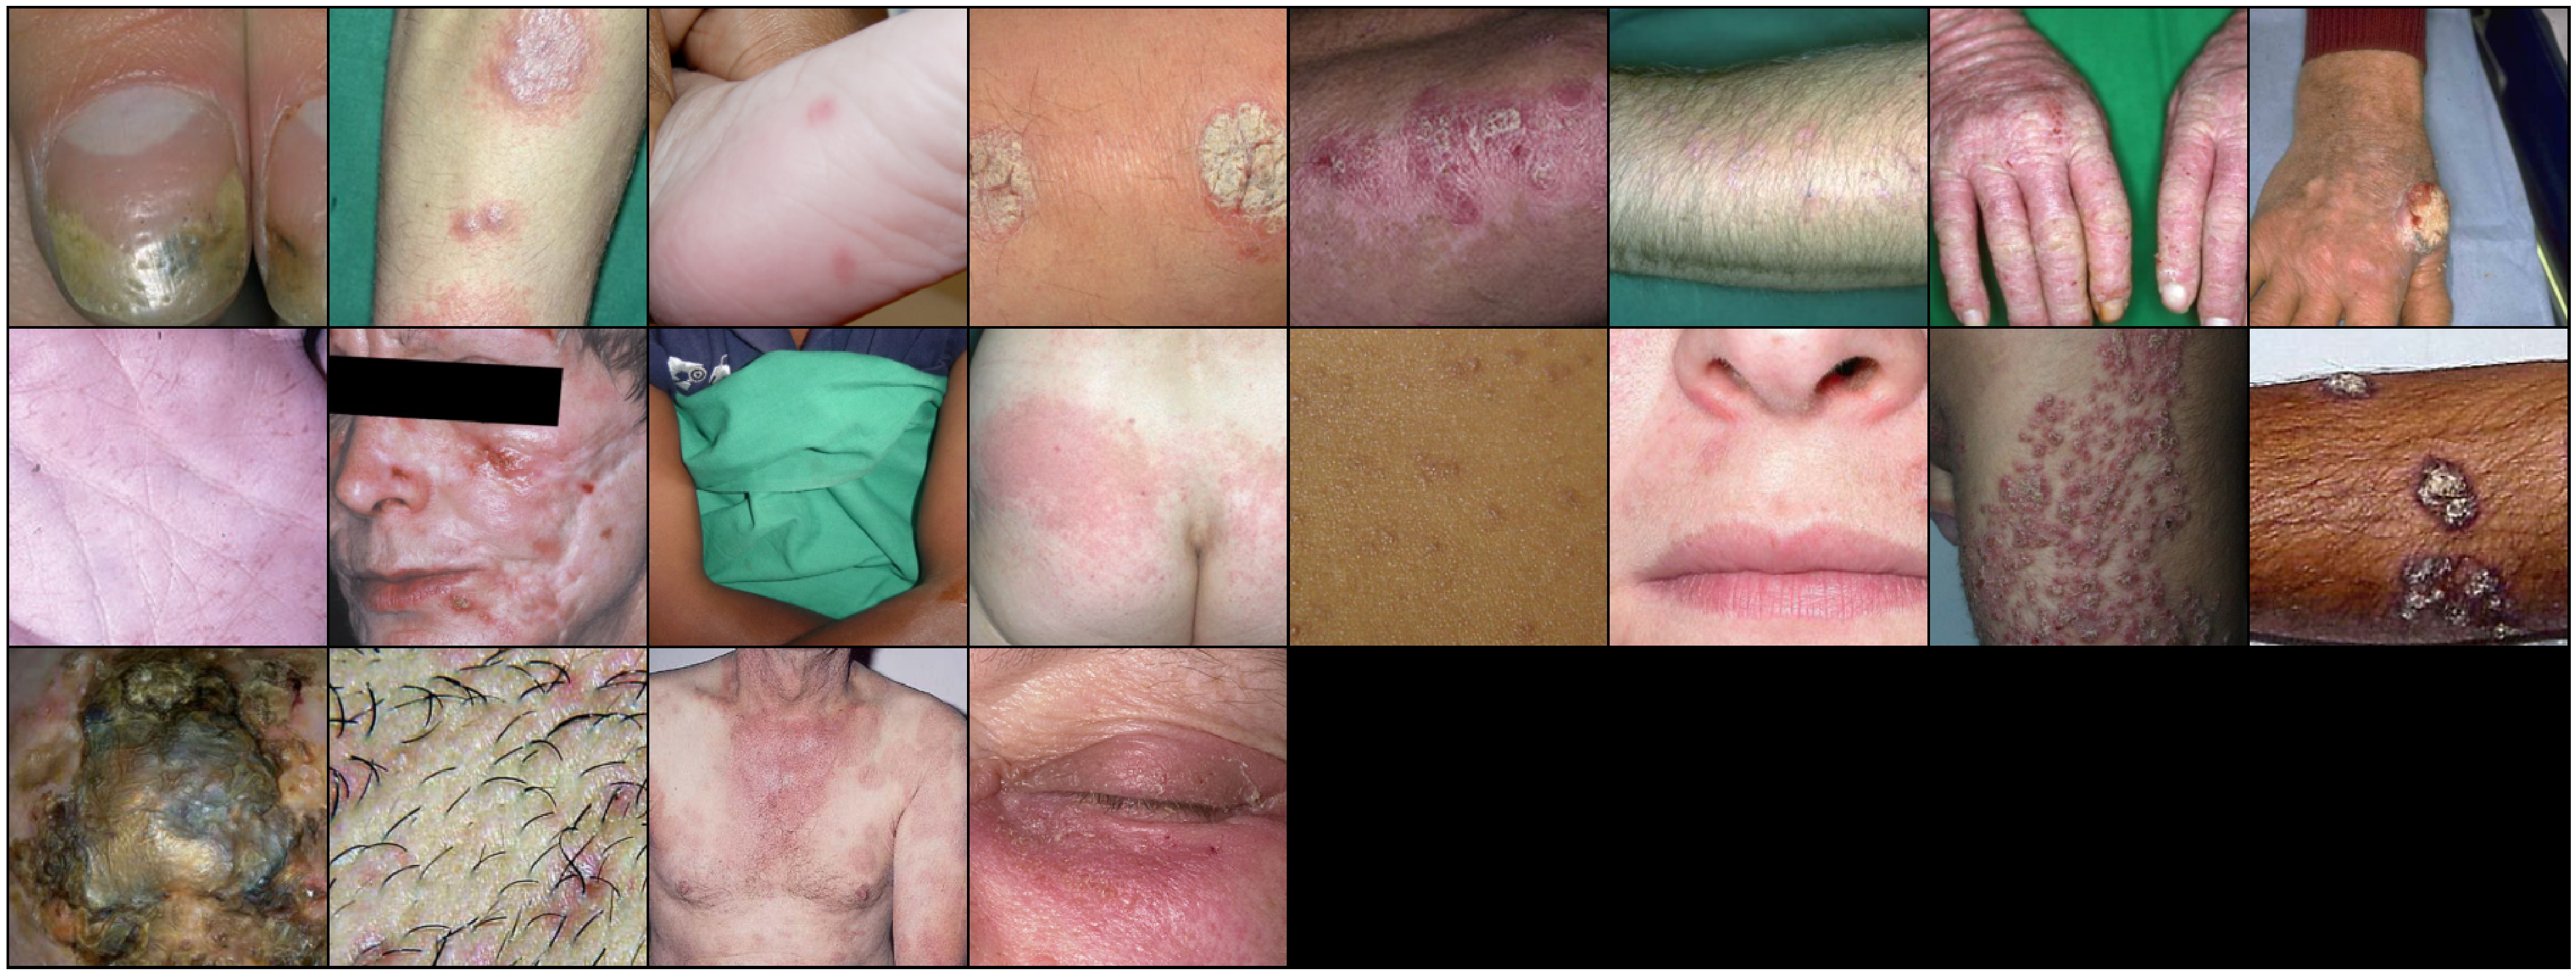

In [16]:
# Show some examples
num_images = 20
explore_data, _ = torch.utils.data.random_split(validation_dataset, [num_images, 890 - num_images - 100])

mosaiclist = []
sets = []
labels = []

for data in explore_data:
    img, label = data
    img_input = img.view(1, 3, 224, 224).to(device)
    with torch.no_grad():
        outputs = model(img_input)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

    img_index = 0
    img_pi = probs[img_index].argsort()[::-1]
    img_srt = np.take_along_axis(probs[img_index], img_pi, axis=0).cumsum()
    prediction_set = np.take_along_axis(img_srt <= qhat, img_pi.argsort(), axis=0)

    unnormalized_img = (img * torch.Tensor([0.229, 0.224, 0.225]).view(-1,1,1))+torch.Tensor([0.485, 0.456, 0.406]).view(-1,1,1)

    sets = sets + [prediction_set]
    labels = labels + [class_names[label]]
    mosaiclist = mosaiclist + [unnormalized_img]

grid = torchvision.utils.make_grid(mosaiclist)

fig, ax = plt.subplots(figsize=(min(num_images, 9) * 5, np.floor(num_images / 9 + 1) * 5))
ax.imshow(grid.permute(1, 2, 0), interpolation='nearest')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()

for i in range(len(mosaiclist)):
    set_names = [class_names[s] for s in np.where(sets[i])[0]]
    print(f"Image {i} has label '{labels[i]}', and the predictive set is {set_names}.")



<ipython-input-17-572453f9b9ca>:20: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")


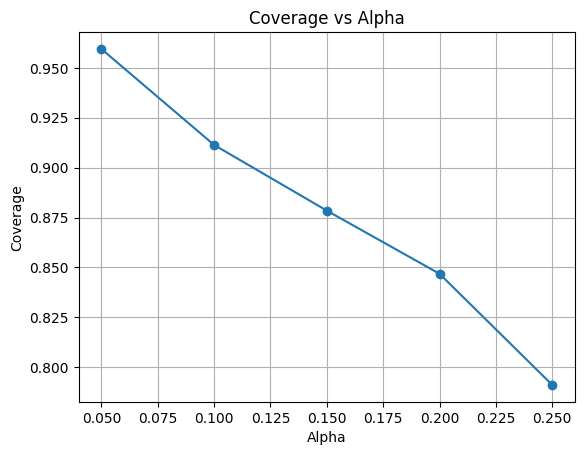

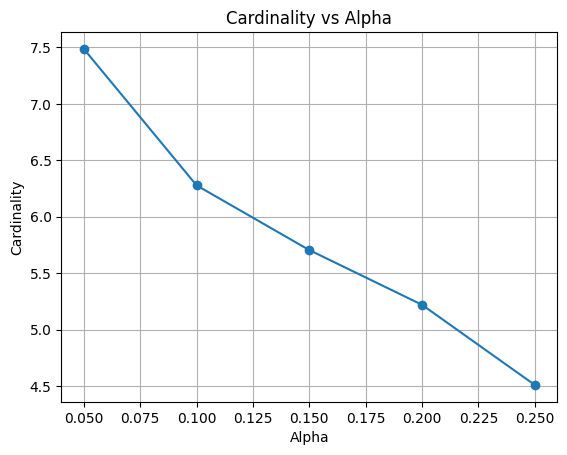

In [17]:
def get_coverage(labels: np.ndarray, prediction_sets: np.ndarray) -> float:
    k = len(labels)
    assert k
    correct = 0
    for i in range(k):
        correct += prediction_sets[i, labels[i]]
    return correct / k

def get_cardinality(prediction_sets: np.ndarray) -> float:
    k = len(prediction_sets)
    assert k
    return np.count_nonzero(prediction_sets) / k

import matplotlib.pyplot as plt

alphas = [0.05, 0.1, 0.15, 0.2, 0.25]
results = []

for alpha in alphas:
    qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")
    prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

    coverage = get_coverage(val_labels, prediction_sets)
    cardinality = get_cardinality(prediction_sets)
    results.append((coverage, cardinality))

# Separate coverage and cardinality values
coverages, cardinalities = zip(*results)

# Plot coverage vs alpha
plt.figure()
plt.plot(alphas, coverages, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Coverage')
plt.title('Coverage vs Alpha')
plt.grid()

# Plot cardinality vs alpha
plt.figure()
plt.plot(alphas, cardinalities, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Cardinality')
plt.title('Cardinality vs Alpha')
plt.grid()

# Display the graphs
plt.show()


This method was first introduced in https://arxiv.org/abs/2006.02544 and studied further for image classifiers in https://arxiv.org/abs/2009.14193.